In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
import warnings
import re
import os
warnings.filterwarnings('ignore')

print("All tools are ready!")


All tools are ready!


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("default")
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["font.size"] = 12

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 200)

In [6]:
DATA_PATH = "data"
DATA2_PATH = "data2"

try:
    train_data = pd.read_csv(os.path.join(DATA_PATH, "train.csv"))
    test_data = pd.read_csv(os.path.join(DATA_PATH, "test.csv"))

    train_data2 = pd.read_csv(os.path.join(DATA2_PATH, "train_dataset.csv"))
    test_data2 = pd.read_csv(os.path.join(DATA2_PATH, "test_dataset.csv"))

    test_ids = test_data['id']
    
    train_data = train_data.drop('id', axis=1)
    test_data = test_data.drop('id', axis=1)

    def clean_col_names(df):
        cols = df.columns
        new_cols = []
        for col in cols:
            new_col = re.sub(r'[^A-Za-z0-9_]+', '', col)
            new_cols.append(new_col.lower())
        df.columns = new_cols
        return df

    train_data = clean_col_names(train_data)
    test_data = clean_col_names(test_data)
    train_data2 = clean_col_names(train_data2)
    test_data2 = clean_col_names(test_data2)


    df_train = pd.concat([train_data, train_data2, test_data2], ignore_index=True)
    df_test = test_data
    
    df_train = df_train.drop_duplicates()

    df_train.dropna(subset=['smoking'], inplace=True)
    
    df_train['smoking'] = df_train['smoking'].astype(int)

    print(f"Original training data had {train_data.shape[0]} rows.")
    print(f"Our new combined training data has {df_train.shape[0]} rows.")
    print(f"Our final test data has {test_data.shape[0]} rows to predict.\n")

except FileNotFoundError:
    print(f"Couldn't find the files. Check this path: {DATA_PATH} and {DATA2_PATH}")

df = df_train

Original training data had 15000 rows.
Our new combined training data has 48467 rows.
Our final test data has 10000 rows to predict.



In [7]:
print("shape:", df.shape)
df.info()

shape: (48467, 23)
<class 'pandas.core.frame.DataFrame'>
Index: 48467 entries, 0 to 53983
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                48467 non-null  float64
 1   heightcm           48467 non-null  float64
 2   weightkg           48467 non-null  float64
 3   waistcm            48467 non-null  float64
 4   eyesightleft       48467 non-null  float64
 5   eyesightright      48467 non-null  float64
 6   hearingleft        48467 non-null  float64
 7   hearingright       48467 non-null  float64
 8   systolic           48467 non-null  float64
 9   relaxation         48467 non-null  float64
 10  fastingbloodsugar  48467 non-null  float64
 11  cholesterol        48467 non-null  float64
 12  triglyceride       48467 non-null  float64
 13  hdl                48467 non-null  float64
 14  ldl                48467 non-null  float64
 15  hemoglobin         48467 non-null  float64
 16  urinepro

In [8]:
df.describe()

,age,heightcm,weightkg,waistcm,eyesightleft,eyesightright,hearingleft,hearingright,systolic,relaxation,fastingbloodsugar,cholesterol,triglyceride,hdl,ldl,hemoglobin,urineprotein,serumcreatinine,ast,alt,gtp,dentalcaries,smoking
count,48467.000000,48467.000000,48467.000000,48467.000000,48467.000000,48467.000000,48467.000000,48467.000000,48467.000000,48467.000000,48467.000000,48467.000000,48467.000000,48467.000000,48467.00000,48467.000000,48467.000000,48467.000000,48467.000000,48467.000000,48467.000000,48467.000000,48467.000000
mean,43.707677,164.647554,65.361896,81.509726,1.018722,1.014206,1.019065,1.019849,120.765985,75.644934,97.880228,195.175666,118.966018,57.373037,114.58805,14.586500,1.065282,0.880133,24.968762,25.175460,35.713001,0.193369,0.365919
std,11.620122,9.018708,12.362813,8.936193,0.444070,0.446782,0.136753,0.139481,12.939568,9.153294,18.028536,32.398174,66.113618,13.702143,37.55291,1.512311,0.349362,0.206175,16.030948,27.048231,43.406524,0.394944,0.481692
min,20.000000,130.000000,30.000000,51.000000,0.100000,0.100000,1.000000,1.000000,71.000000,40.000000,46.000000,55.000000,8.000000,4.000000,1.00000,4.900000,1.000000,0.100000,6.000000,1.000000,2.000000,0.000000,0.000000
25%,40.000000,160.000000,55.000000,75.000000,0.800000,0.800000,1.000000,1.000000,111.000000,70.000000,89.000000,174.000000,73.000000,48.000000,95.00000,13.600000,1.000000,0.800000,19.000000,15.000000,16.000000,0.000000,0.000000
50%,40.000000,165.000000,65.000000,81.000000,1.000000,1.000000,1.000000,1.000000,120.000000,76.000000,95.000000,193.000000,101.000000,56.000000,113.00000,14.800000,1.000000,0.900000,22.000000,20.000000,24.000000,0.000000,0.000000
75%,50.000000,170.000000,75.000000,87.000000,1.200000,1.200000,1.000000,1.000000,130.000000,80.000000,102.000000,213.000000,145.000000,65.000000,132.00000,15.700000,1.000000,1.000000,27.000000,29.000000,39.000000,0.000000,1.000000
max,85.000000,190.000000,135.000000,129.000000,9.900000,9.900000,2.000000,2.000000,233.000000,146.000000,423.000000,445.000000,999.000000,359.000000,1860.00000,21.100000,6.000000,11.600000,1090.000000,2914.000000,999.000000,1.000000,1.000000


In [9]:
# 欠損数と割合
missing = pd.DataFrame({
    "count": df.isna().sum(),
    "ratio": df.isna().mean()
}).sort_values("ratio", ascending=False)

missing

,count,ratio
age,0,0.0
triglyceride,0,0.0
dentalcaries,0,0.0
gtp,0,0.0
alt,0,0.0
ast,0,0.0
serumcreatinine,0,0.0
urineprotein,0,0.0
hemoglobin,0,0.0
ldl,0,0.0


In [10]:
# 重複行
df.duplicated().sum()

np.int64(0)

In [12]:
df["smoking"].value_counts()

smoking
0    30732
1    17735
Name: count, dtype: int64

In [13]:
df["smoking"].value_counts(normalize=True)

smoking
0    0.634081
1    0.365919
Name: proportion, dtype: float64

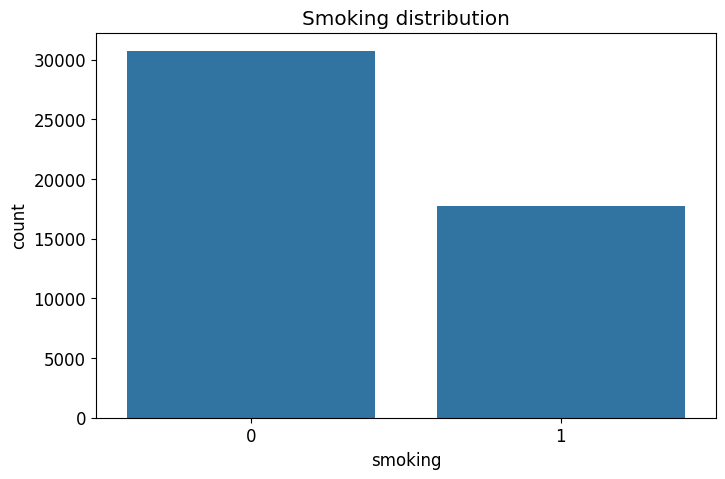

In [14]:
sns.countplot(x="smoking", data=df)
plt.title("Smoking distribution")
plt.show()


In [15]:
target = "smoking"

num_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
num_cols.remove(target)

cat_cols = [c for c in df.columns if c not in num_cols + [target]]

num_cols, cat_cols

(['age',
  'heightcm',
  'weightkg',
  'waistcm',
  'eyesightleft',
  'eyesightright',
  'hearingleft',
  'hearingright',
  'systolic',
  'relaxation',
  'fastingbloodsugar',
  'cholesterol',
  'triglyceride',
  'hdl',
  'ldl',
  'hemoglobin',
  'urineprotein',
  'serumcreatinine',
  'ast',
  'alt',
  'gtp',
  'dentalcaries'],
 [])

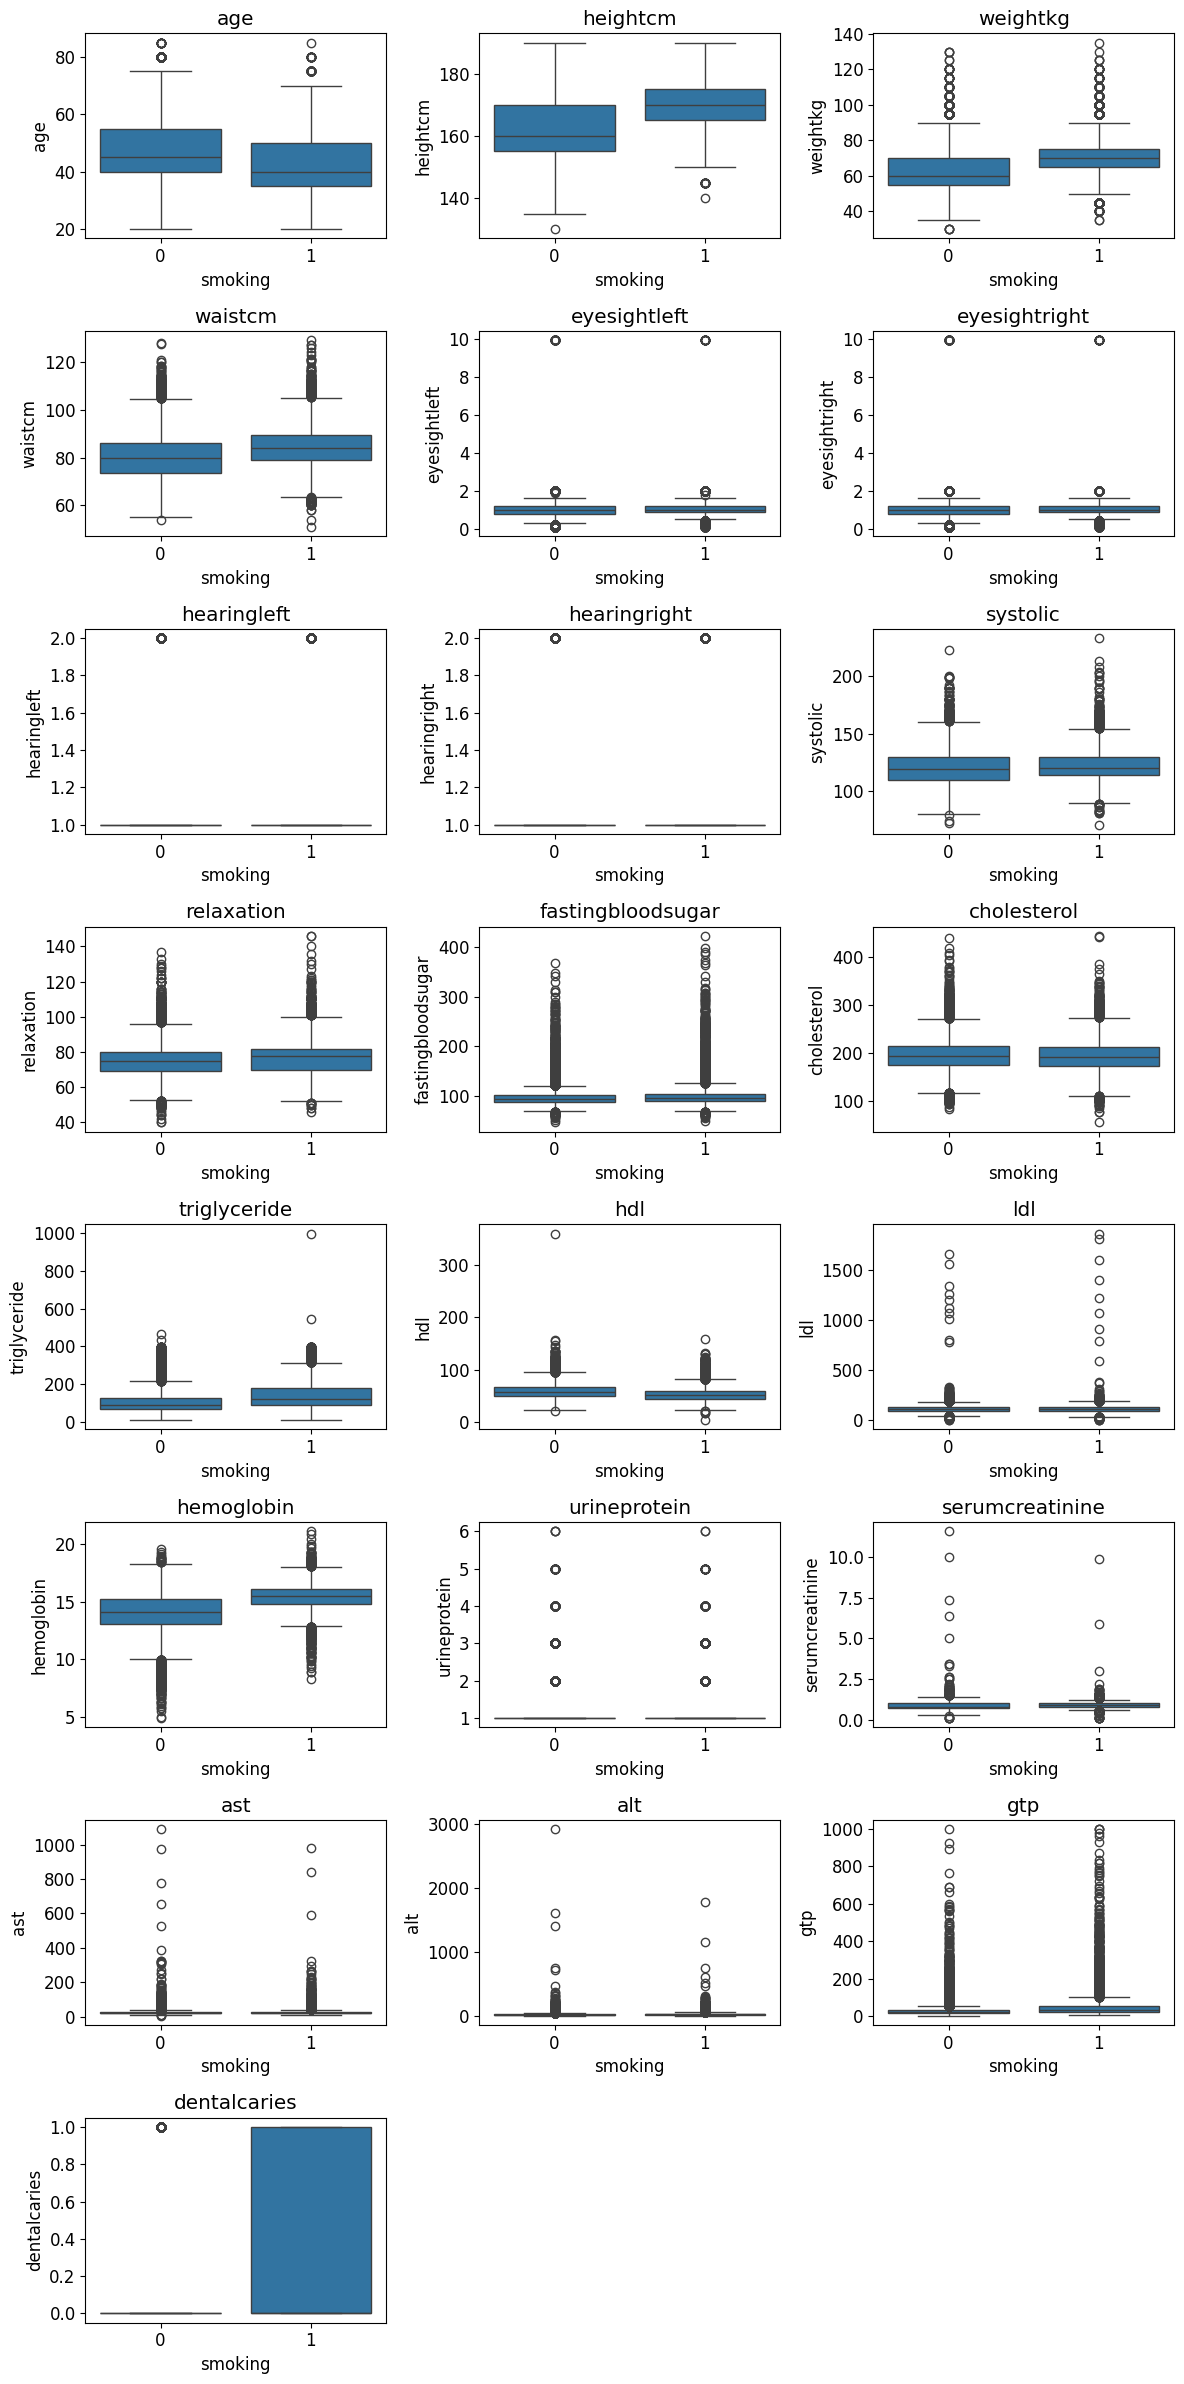

In [18]:
n_cols = 3
n_rows = int(np.ceil(len(num_cols) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 3))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.boxplot(x="smoking", y=col, data=df, ax=axes[i])
    axes[i].set_title(col)

# 余ったsubplotを消す
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


In [19]:
mean_diff = (
    df.groupby("smoking")[num_cols]
    .mean()
    .T
)

mean_diff["diff"] = mean_diff[1] - mean_diff[0]
mean_diff.sort_values("diff", ascending=False)

smoking,0,1,diff
triglyceride,105.719055,141.920947,36.201892
gtp,27.802714,49.420299,21.617585
weightkg,62.299720,70.668170,8.368450
heightcm,161.740368,169.685255,7.944887
alt,22.961636,29.011672,6.050036
waistcm,79.856052,84.375286,4.519234
fastingbloodsugar,96.606729,100.087003,3.480274
relaxation,74.848497,77.025035,2.176539
systolic,119.972830,122.140400,2.167571
ast,24.207764,26.287454,2.079690


In [20]:
corr = df[num_cols + ["smoking"]].corr()

corr["smoking"].sort_values()


hdl                 -0.205019
age                 -0.179559
ldl                 -0.040189
cholesterol         -0.032128
hearingleft         -0.021020
hearingright        -0.015973
urineprotein         0.011186
ast                  0.062490
eyesightleft         0.073489
eyesightright        0.076436
systolic             0.080691
fastingbloodsugar    0.092987
alt                  0.107743
dentalcaries         0.113404
relaxation           0.114540
gtp                  0.239895
waistcm              0.243602
serumcreatinine      0.244374
triglyceride         0.263760
weightkg             0.326060
heightcm             0.424339
hemoglobin           0.428778
smoking              1.000000
Name: smoking, dtype: float64

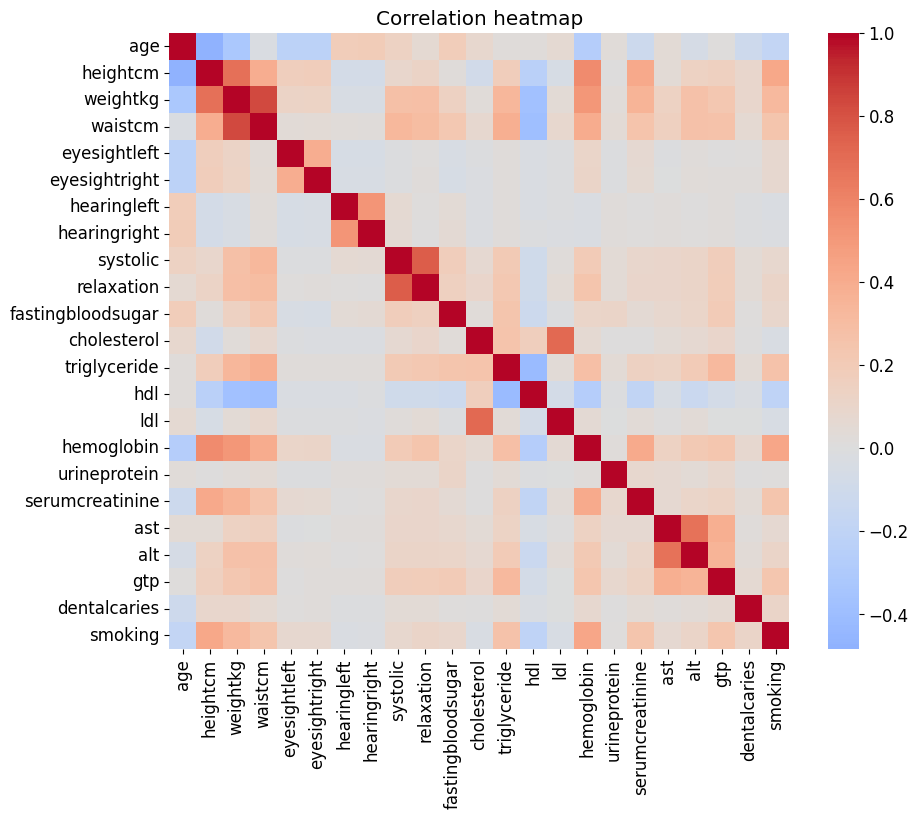

In [21]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation heatmap")
plt.show()


In [30]:
df_feat = df.copy()

# BMI
df_feat["BMI"] = df_feat["weightkg"] / (df_feat["heightcm"] / 100) ** 2

# 腹囲 / 身長
df_feat["waist_height_ratio"] = df_feat["waistcm"] / df_feat["heightcm"]

# 肝機能系
df_feat["AST_ALT_ratio"] = df_feat["ast"] / (df_feat["alt"] + 1e-6)

# 脂質比
df_feat["LDL_HDL_ratio"] = df_feat["ldl"] / (df_feat["hdl"] + 1e-6)


df_feat[["BMI", "waist_height_ratio", "AST_ALT_ratio", "LDL_HDL_ratio"]].head()



,BMI,waist_height_ratio,AST_ALT_ratio,LDL_HDL_ratio
0,29.136316,0.537419,1.625000,1.358974
1,26.122449,0.494286,0.906250,1.882353
2,33.333333,0.600000,1.304348,2.727273
3,22.491349,0.470588,1.038461,2.052632
4,27.343750,0.531250,1.538461,2.290909


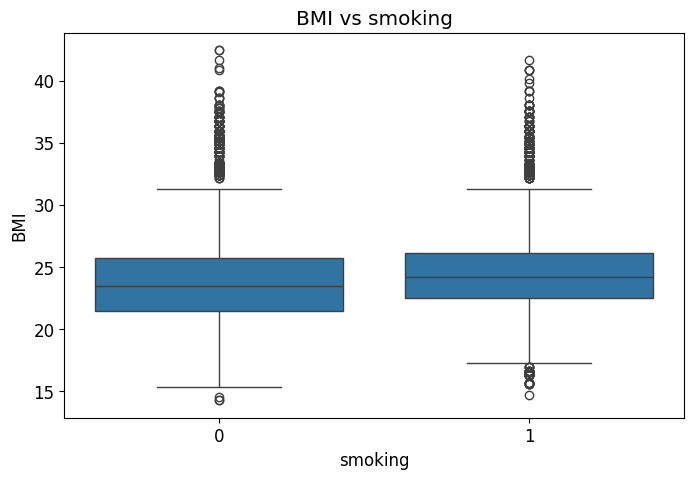

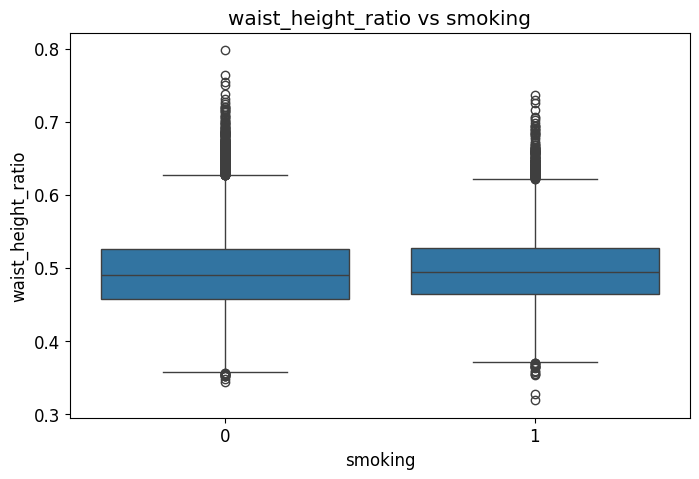

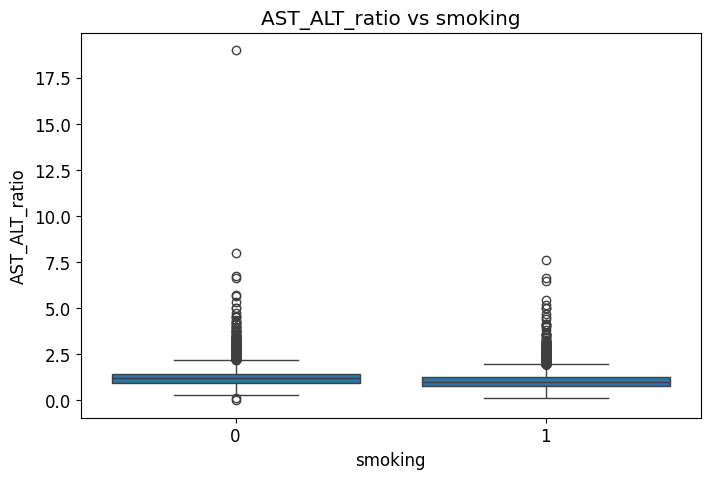

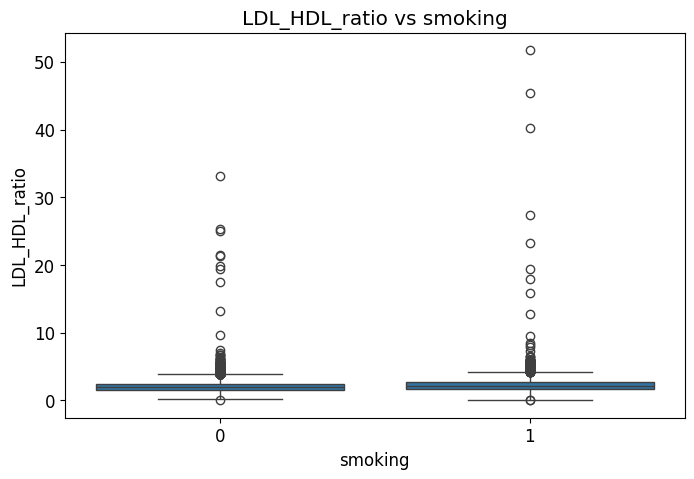

In [31]:
new_cols = [
    "BMI",
    "waist_height_ratio",
    "AST_ALT_ratio",
    "LDL_HDL_ratio"
]

for col in new_cols:
    plt.figure()
    sns.boxplot(x="smoking", y=col, data=df_feat)
    plt.title(f"{col} vs smoking")
    plt.show()

In [32]:
corr_new = df_feat[new_cols + ["smoking"]].corr()
corr_new["smoking"].sort_values()

AST_ALT_ratio        -0.201482
waist_height_ratio    0.031785
LDL_HDL_ratio         0.090741
BMI                   0.115106
smoking               1.000000
Name: smoking, dtype: float64